In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
import time
from statsmodels.tsa.ar_model import AutoReg
import plotly.express as px

In [2]:
#load data in pandas dataframe
df = pd.read_csv('accra_air_quality.csv',index_col='timestamp')

In [3]:
df.head()

,lat,lon,P2
timestamp,,,
2019-12-04 18:00:00+00:00,5.58,-0.17,4.6
2019-12-04 19:00:00+00:00,5.58,-0.17,20.4
2019-12-04 20:00:00+00:00,5.58,-0.17,21.5
2019-12-04 21:00:00+00:00,5.58,-0.17,21.5
2019-12-04 22:00:00+00:00,5.58,-0.17,21.7


In [4]:
#drop lat and lon column 
columns_to_keep = ["P2"]
df = df[columns_to_keep]

In [10]:
#convert the timestamp datatype to datetime dtype
df.index = pd.to_datetime(df.index, infer_datetime_format=True)
df.index = df.index.tz_convert("Africa/Accra")

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10067 entries, 2019-12-04 18:00:00+00:00 to 2021-03-23 10:00:00+00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   P2      10067 non-null  float64
dtypes: float64(1)
memory usage: 157.3 KB


In [23]:
y = df["P2"].resample("1H").mean().fillna(method="ffill")

### Explore


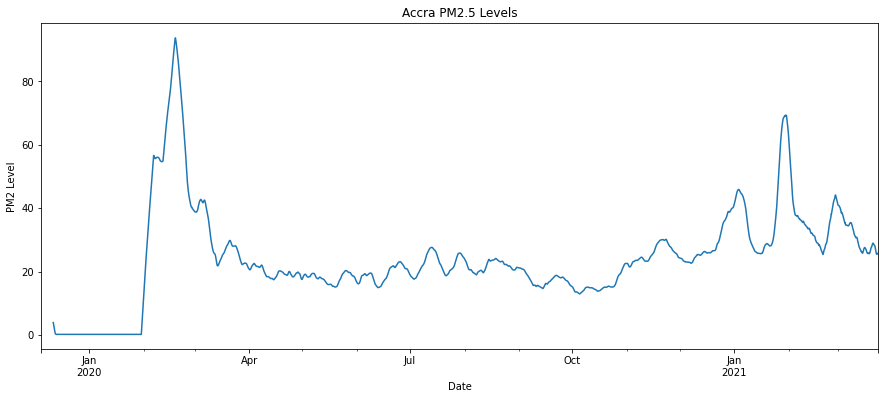

In [24]:
fig, ax= plt.subplots(figsize= (15,6))
y.rolling(168).mean().plot(ax = ax, ylabel = "PM2 Level", xlabel = 'Date')
ax.set_title("Accra PM2.5 Levels");


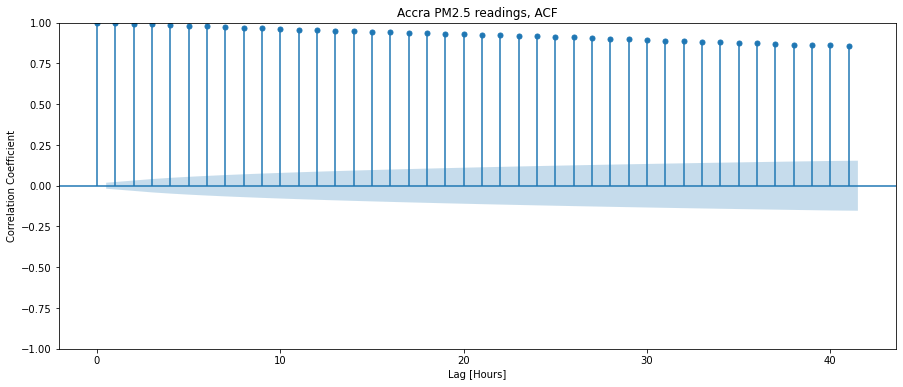

In [25]:
#plotting the ACF chart 
fig, ax= plt.subplots(figsize= (15,6))
plot_acf(y, ax =ax)
plt.xlabel("Lag [Hours]")
plt.ylabel("Correlation Coefficient")
plt.title("Accra PM2.5 readings, ACF");

C:\Users\johna\anaconda3\anaconda31\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


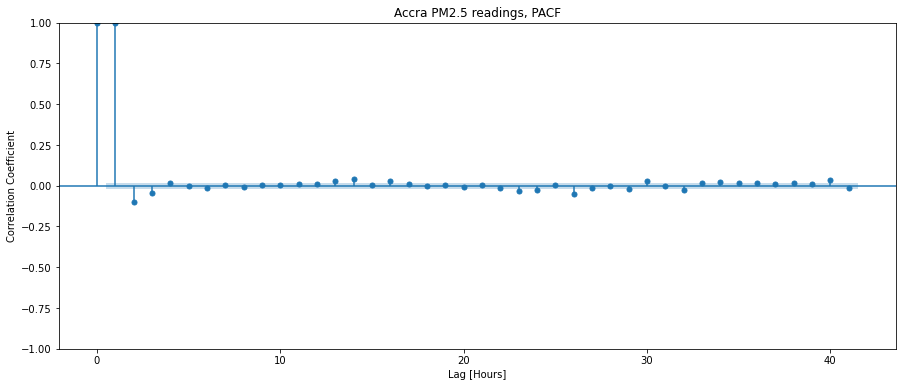

In [26]:
#plotting the PACF chart 
fig, ax= plt.subplots(figsize= (15,6))
plot_pacf(y, ax =ax)
plt.xlabel("Lag [Hours]")
plt.ylabel("Correlation Coefficient")
plt.title("Accra PM2.5 readings, PACF");

### Split data


In [28]:
#splitting the data into test data and training data
#90% will be used to train the data and 10% will be used ot test the moel
cutoff_test = int(0.9*len(df))
y_train = y.iloc[:cutoff_test]
y_test = y.iloc[cutoff_test:]
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

y_train shape:  (9060,)
y_test shape:  (2333,)


### Model Building

An AutoRegressive model will be used to train the model

#### Baseline

In [29]:
#establishing the baseline for the model using mean absolute error
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean]* len(y_train)
mae_baseline = mean_absolute_error(y_train,y_pred_baseline)
print("Mean P2 Reading:", y_train_mean)
print("Baseline MAE:", mae_baseline)

Mean P2 Reading: 21.161456953642624
Baseline MAE: 9.737374237972055


In [32]:
#setting hyper parameters
p_params = range(1,41)
maes = []
for p in p_params:
    model = AutoReg(y_train,lags=p).fit()
    # Generate in-sample predictions
    y_pred = model.predict()
    #calculate training MAE
    mae = mean_absolute_error(y_train.iloc[p:], y_pred.iloc[p:])
    #add MAE to dictionary
    maes.append(mae)

mae_series = pd.Series(maes, name="mae", index=p_params)
mae_series.head()

1    0.290693
2    0.276656
3    0.275672
4    0.275237
5    0.275251
Name: mae, dtype: float64

In [35]:
mae_series

1     0.290693
2     0.276656
3     0.275672
4     0.275237
5     0.275251
6     0.275481
7     0.275485
8     0.275388
9     0.275410
10    0.275510
11    0.275440
12    0.275415
13    0.275290
14    0.275187
15    0.275189
16    0.275115
17    0.275136
18    0.275156
19    0.275244
20    0.275200
21    0.275204
22    0.275216
23    0.275077
24    0.274602
25    0.267550
26    0.267881
27    0.267392
28    0.267286
29    0.267259
30    0.267161
31    0.267132
32    0.267175
33    0.267211
34    0.267243
35    0.267266
36    0.267317
37    0.267326
38    0.267379
39    0.267361
40    0.267379
Name: mae, dtype: float64

In [36]:
best_p = 31
best_model = AutoReg(y_train, lags=best_p).fit()

In [37]:
y_train_resid = best_model.resid
y_train_resid.name = "residuals"
y_train_resid.head()

timestamp
2019-12-06 01:00:00+00:00    0.139440
2019-12-06 02:00:00+00:00    0.319830
2019-12-06 03:00:00+00:00    0.046757
2019-12-06 04:00:00+00:00    0.088216
2019-12-06 05:00:00+00:00   -1.324401
Freq: H, Name: residuals, dtype: float64

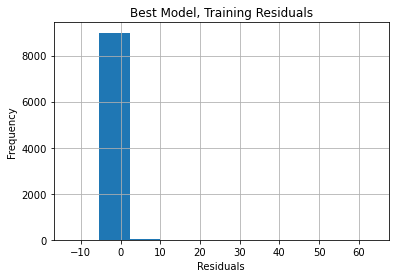

In [40]:
# Plot histogram of residuals
y_train_resid.hist()
plt.title("Best Model, Training Residuals")
plt.ylabel("Frequency")
plt.xlabel("Residuals");

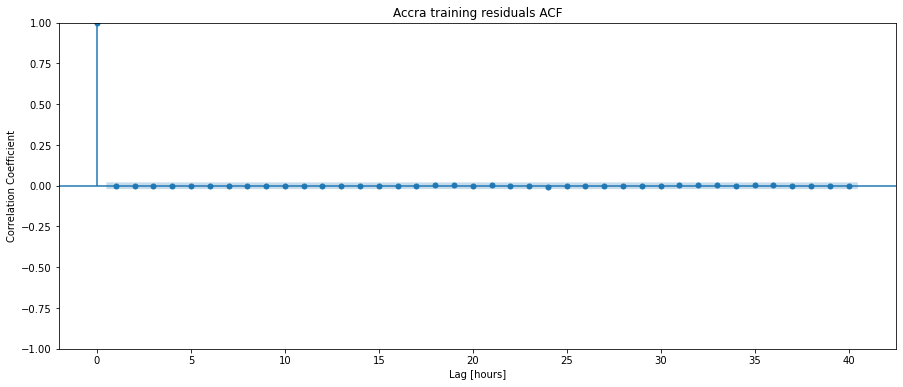

In [43]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid,ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient")
plt.title("Accra training residuals ACF");

performing walk forward validation for model using the entire test set `y_test`

In [56]:
y_pred_wfv = pd.Series(dtype="float")
history = y_train.copy()

for i in range(len(y_test)):
    model = AutoReg(history, lags= best_p).fit()
    next_pred = model.forecast()
    y_pred_wfv = pd.concat([y_pred_wfv,next_pred])
    history = pd.concat([history, y_test[next_pred.index]])
y_pred_wfv.name = "prediction"
y_pred_wfv.index.name = "timestamp"
y_pred_wfv.head()

timestamp
2020-12-16 06:00:00+00:00    27.422832
2020-12-16 07:00:00+00:00    27.408697
2020-12-16 08:00:00+00:00    26.995007
2020-12-16 09:00:00+00:00    26.914178
2020-12-16 10:00:00+00:00    26.501044
Freq: H, Name: prediction, dtype: float64

In [70]:
df_pred_test = pd.DataFrame({
    "y_test":y_test,
    "y_pred_wfv":y_pred_wfv
})
fig = px.line(df_pred_test)
fig.update_layout(
    title="Accra, WFV Predictions",
    xaxis_title="Date",
    yaxis_title="PM2.5 Level",
)
# fig.write_image("image", scale=1, height=500, width=700)

fig.show()